In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from all_models import dual_model_sudden, dual_model_gradual, model_sudden, model_gradual
import scipy.stats as stat

In [34]:
fits_dual = pickle.load(open('fit_dual_CV_704.pickle', 'rb'))
fits_single = pickle.load(open('fit_single_CV_704.pickle', 'rb'))
curvatures_smooth = pickle.load(open('curvatures_smooth.pickle', 'rb'))
curvatures_smooth = curvatures_smooth/90

(14, 12, 64)

In [15]:
dual_errors = np.zeros((100, 14, 704))
single_errors = np.zeros((100, 14, 704))
for i in range(100):
    for participant in range(14):
        if participant%2 == 0:
            dual_errors[i][participant] = dual_model_sudden(704, fits_dual[i][participant][0], fits_dual[i][participant][1], fits_dual[i][participant][2], fits_dual[i][participant][3])[0]
            single_errors[i][participant] = model_sudden(704, fits_single[i][participant][0], fits_single[i][participant][1])[0]
        else:
            dual_errors[i][participant] = dual_model_gradual(704, fits_dual[i][participant][0], fits_dual[i][participant][1], fits_dual[i][participant][2], fits_dual[i][participant][3])[0]
            single_errors[i][participant] = model_gradual(704, fits_single[i][participant][0], fits_single[i][participant][1])[0]

In [66]:
ll_single = np.zeros((100, 14, 704))
ll_dual = np.zeros((100, 14, 704))
for i in range(100):
    for participant in range(14):
        ll_dual[i][participant] = stat.norm.logpdf(np.ravel(curvatures_smooth[participant][1:]), dual_errors[i][participant], fits_dual[i][participant][5])
        ll_single[i][participant] = stat.norm.logpdf(np.ravel(curvatures_smooth[participant][1:]), single_errors[i][participant], fits_single[i][participant][3])

In [59]:
def get_lls(fits, ll, rotate):
    ll_rotate_train = np.zeros((100, 14))
    ll_transfer_train = np.zeros((100, 14))
    ll_rotate_test = np.zeros((100, 14))
    ll_transfer_test = np.zeros((100, 14))
    ll_all_test = np.zeros((100, 14))
    ll_all_train = np.zeros((100, 14))

    for i in range(100):
        for participant in range(14):
            rotate_train_indices = fits[i][participant, -1][fits[i][participant, -1] < 640]
            transfer_train_indices = fits[i][participant, -1][fits[i][participant, -1] >= 640]
            
            all_test_indices = np.delete(range(704), fits[i][participant, -1])
            rotate_test_indices = all_test_indices[all_test_indices<640]
            transfer_test_indices = all_test_indices[all_test_indices>=640]
            #if rotate:
            ll_rotate_train[i][participant] = sum(ll[i][participant][rotate_train_indices])
            ll_rotate_test[i][participant] = sum(ll[i][participant][rotate_test_indices])
            #else:
            ll_transfer_train[i][participant] = sum(ll[i][participant][transfer_train_indices])
            ll_transfer_test[i][participant] = sum(ll[i][participant][transfer_test_indices])
            #Uncomment for combined rotate + transfer
            ll_all_test[i][participant] = sum(ll[i][participant][all_test_indices])
            ll_all_train[i][participant] = sum(ll[i][participant][fits[i][participant, -1]])
            
    return [ll_rotate_train, ll_rotate_test, ll_transfer_train, ll_transfer_test, ll_all_train, ll_all_test]

In [69]:
ll_duals = np.array(get_lls(fits_dual, ll_dual, 0))
ll_singles = np.array(get_lls(fits_single, ll_single, 0))

In [70]:
def get_train_test_split(ll_selected, ll_compared, model_selected):
    d = {'Rotation': np.ravel(np.row_stack((np.repeat('Sudden', 14), np.repeat('Gradual', 14)))),
     'Set': np.ravel(np.row_stack((np.repeat('Train', 7), np.repeat('Test', 7), np.repeat('Train', 7), np.repeat('Test', 7))))}
    df = pd.DataFrame(d)
    df[model_selected] = np.concatenate((
    sum(ll_compared[4][:, 0::2] <= ll_selected[4][:, 0::2]), 
    sum(ll_compared[5][:, 0::2] <= ll_selected[5][:, 0::2]),

    sum(ll_compared[4][:, 1::2] <= ll_selected[4][:, 1::2]), 
    sum(ll_compared[5][:, 1::2] <= ll_selected[5][:, 1::2]),
    ))
    return df

In [71]:
df_train_test = get_train_test_split(ll_duals, ll_singles, "Dual_Selected")

Text(0.5, 0.98, 'Compared to Single')

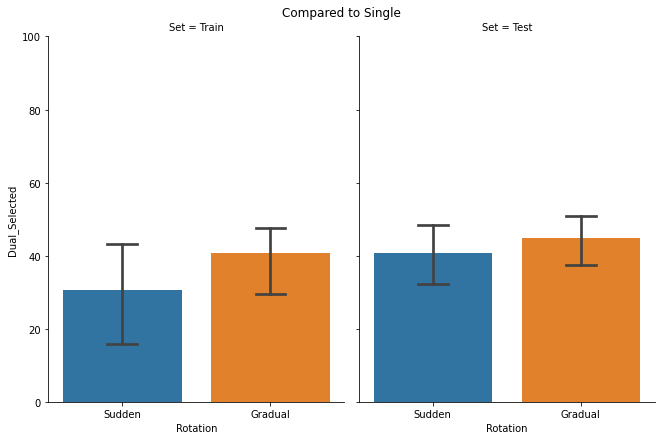

In [73]:
g = sns.catplot(x="Rotation", y="Dual_Selected", col="Set", 
                capsize=.2, height=6, aspect=.75,ci = 95,
                kind = 'bar', data=df_train_test)
plt.subplots_adjust(top=0.91)
plt.ylim((0, 100))
g.fig.suptitle('Compared to Single')
